In [0]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import warnings
import numpy as np
import os
from PIL import Image


from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.applications.imagenet_utils import preprocess_input as _preprocess_input
import keras.backend as K
#from keras_contrib.layers import SubPixelUpscaling

In [0]:
DENSENET_121_WEIGHTS_PATH = r'https://github.com/titu1994/DenseNet/releases/download/v3.0/DenseNet-BC-121-32.h5'
DENSENET_161_WEIGHTS_PATH = (r'https://github.com/titu1994/DenseNet/releases/download/v3.0/DenseNet-BC-161-48.h5')
DENSENET_169_WEIGHTS_PATH = (r'https://github.com/titu1994/DenseNet/releases/download/v3.0/DenseNet-BC-169-32.h5')
DENSENET_121_WEIGHTS_PATH_NO_TOP = r'https://github.com/titu1994/DenseNet/releases/download/v3.0/DenseNet-BC-121-32-no-top.h5'
                                   
DENSENET_161_WEIGHTS_PATH_NO_TOP = r'https://github.com/titu1994/DenseNet/releases/download/v3.0/DenseNet-BC-161-48-no-top.h5'
                                   
DENSENET_169_WEIGHTS_PATH_NO_TOP = r'https://github.com/titu1994/DenseNet/releases/download/v3.0/DenseNet-BC-169-32-no-top.h5'
                                    


In [114]:
!git clone https://github.com/DhanashriPalodkar/imageet32x32/

fatal: destination path 'imageet32x32' already exists and is not an empty directory.


In [0]:
def get_annotations_map():
    valAnnotationsPath = r'imageet32x32/val/val_annotations.txt'
    valAnnotationsFile = open(valAnnotationsPath, 'r')
    valAnnotationsContents = valAnnotationsFile.read()
    valAnnotations = {}

    for line in valAnnotationsContents.splitlines():
        pieces = line.strip().split()
        valAnnotations[pieces[0]] = pieces[1]

    return valAnnotations

Loading 200 classes
loading training images...
finished loading training images
loading test images...
finished loading test images
0
0
1
1


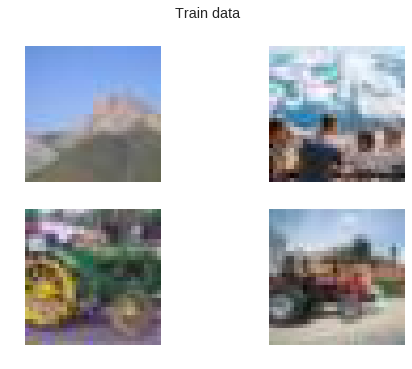

87
100
132
15


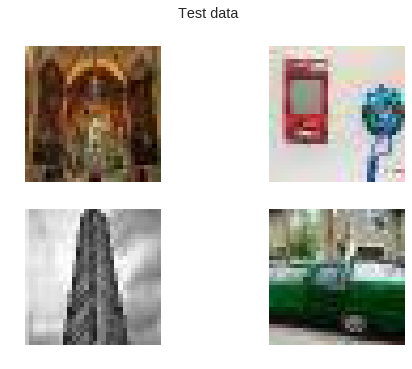

In [116]:
def load_images(path,num_classes):
   #Load images

   print('Loading ' + str(num_classes) + ' classes')

   X_train=np.zeros([num_classes*500,3,32,32],dtype='uint8')
   y_train=np.zeros([num_classes*500], dtype='uint8')

   trainPath='imageet32x32/train'

   print('loading training images...');

   i=0
   j=0
   annotations={}
   for sChild in os.listdir(trainPath):
       sChildPath = os.path.join(os.path.join(trainPath,sChild),'images')
       annotations[sChild]=j
       for c in os.listdir(sChildPath):
           X=np.array(Image.open(os.path.join(sChildPath,c)))
           if len(np.shape(X))==2:
               X_train[i]=np.array([X,X,X])
           else:
               X_train[i]=np.transpose(X,(2,0,1))
           y_train[i]=j
           i+=1
       j+=1
       if (j >= num_classes):
           break

   print('finished loading training images')

   val_annotations_map = get_annotations_map()

   X_test = np.zeros([num_classes*50,3,32,32],dtype='uint8')
   y_test = np.zeros([num_classes*50], dtype='uint8')


   print('loading test images...')

   i = 0
   valPath='imageet32x32/val/images'
   for sChild in os.listdir(valPath):
       if val_annotations_map[sChild] in annotations.keys():
           sChildPath = os.path.join(valPath, sChild)
           X=np.array(Image.open(sChildPath))
           if len(np.shape(X))==2:
               X_test[i]=np.array([X,X,X])
           else:
               X_test[i]=np.transpose(X,(2,0,1))
           y_test[i]=annotations[val_annotations_map[sChild]]
           i+=1
       else:
           pass


   print('finished loading test images')#+str(i)

   return X_train,y_train,X_test,y_test

if __name__ == "__main__":
   import matplotlib.pyplot as plt

   path=r'imageet32x32/train'
   X_train,y_train,X_test,y_test=load_images(path,200)#input data path & numbers of classes


   fig1 = plt.figure()
   fig1.suptitle('Train data')
   ax1 = fig1.add_subplot(221)
   ax1.axis("off")
   ax1.imshow(np.transpose(X_train[0],(1,2,0)))
   print(y_train[0])
   ax2 = fig1.add_subplot(222)
   ax2.axis("off")
   ax2.imshow(np.transpose(X_train[499],(1,2,0)))
   print(y_train[499])
   ax3 = fig1.add_subplot(223)
   ax3.axis("off")
   ax3.imshow(np.transpose(X_train[500],(1,2,0)))
   print(y_train[500])
   ax4 = fig1.add_subplot(224)
   ax4.axis("off")
   ax4.imshow(np.transpose(X_train[999],(1,2,0)))
   print(y_train[999])

   plt.show()

   fig2 = plt.figure()
   fig2.suptitle('Test data')
   ax1 = fig2.add_subplot(221)
   ax1.axis("off")
   ax1.imshow(np.transpose(X_test[0],(1,2,0)))
   print(y_test[0])
   ax2 = fig2.add_subplot(222)
   ax2.axis("off")
   ax2.imshow(np.transpose(X_test[49],(1,2,0)))
   print(y_test[49])
   ax3 = fig2.add_subplot(223)
   ax3.axis("off")
   ax3.imshow(np.transpose(X_test[50],(1,2,0)))
   print(y_test[50])
   ax4 = fig2.add_subplot(224)
   ax4.axis("off")
   ax4.imshow(np.transpose(X_test[99],(1,2,0)))
   print(y_test[99])

   plt.show()

In [0]:
def preprocess_input(x, data_format=None):
    """Preprocesses a tensor encoding a batch of images.
    # Arguments
        x: input Numpy tensor, 4D.
        data_format: data format of the image tensor.
    # Returns
        Preprocessed tensor.
    """
    x = _preprocess_input(x, data_format=data_format)
    x *= 0.017  # scale values
    return x


In [0]:
def DenseNet(input_shape=None,
             depth=40,
             nb_dense_block=3,
             growth_rate=12,
             nb_filter=-1,
             nb_layers_per_block=-1,
             bottleneck=False,
             reduction=0.0,
             dropout_rate=0.0,
             weight_decay=1e-4,
             subsample_initial_block=False,
             include_top=True,
             weights=None,
             input_tensor=None,
             pooling=None,
             classes=10,
             activation='softmax',
             transition_pooling='avg'):
  if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')
      

  if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as ImageNet with `include_top` '
                         'as true, `classes` should be 1000')

  if activation not in ['softmax', 'sigmoid']:
        raise ValueError('activation must be one of "softmax" or "sigmoid"')

  if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')
      
  input_shape = _obtain_input_shape(input_shape,
                                   default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)
  if input_tensor is None:
        img_input = Input(shape=input_shape)
  else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

  x = __create_dense_net(classes, img_input, include_top, depth, nb_dense_block,
                           growth_rate, nb_filter, nb_layers_per_block, bottleneck,
                           reduction, dropout_rate, weight_decay,
                           subsample_initial_block, pooling, activation,
                           transition_pooling)
  if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
  else:
        inputs = img_input
    # Create model.
  model = Model(inputs, x, name='densenet')
  
  # load weights
  if weights == 'imagenet':
    weights_loaded = False
    if ((depth == 121) and (nb_dense_block == 4) and (growth_rate == 32) and
                (nb_filter == 64) and (bottleneck is True) and (reduction == 0.5) and
                subsample_initial_block):
            if include_top:
                weights_path = get_file('DenseNet-BC-121-32.h5',
                                        DENSENET_121_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='a439dd41aa672aef6daba4ee1fd54abd')
            else:
                weights_path = get_file('DenseNet-BC-121-32-no-top.h5',
                                        DENSENET_121_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='55e62a6358af8a0af0eedf399b5aea99')
            model.load_weights(weights_path, by_name=True)
            weights_loaded = True
    if ((depth == 161) and (nb_dense_block == 4) and (growth_rate == 48) and
                (nb_filter == 96) and (bottleneck is True) and (reduction == 0.5) and
                subsample_initial_block):
            if include_top:
                weights_path = get_file('DenseNet-BC-161-48.h5',
                                        DENSENET_161_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='6c326cf4fbdb57d31eff04333a23fcca')
            else:
                weights_path = get_file('DenseNet-BC-161-48-no-top.h5',
                                        DENSENET_161_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='1a9476b79f6b7673acaa2769e6427b92')
            model.load_weights(weights_path, by_name=True)
            weights_loaded = True
    if ((depth == 169) and (nb_dense_block == 4) and (growth_rate == 32) and
                (nb_filter == 64) and (bottleneck is True) and (reduction == 0.5) and
                subsample_initial_block):
            if include_top:
                weights_path = get_file('DenseNet-BC-169-32.h5',
                                        DENSENET_169_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='914869c361303d2e39dec640b4e606a6')
            else:
                weights_path = get_file('DenseNet-BC-169-32-no-top.h5',
                                        DENSENET_169_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='89c19e8276cfd10585d5fadc1df6859e')
            model.load_weights(weights_path, by_name=True)
            weights_loaded = True 
    if weights_loaded:
            if K.backend() == 'theano':
                convert_all_kernels_in_model(model)

            if ((K.image_data_format() == 'channels_first') and
                    (K.backend() == 'tensorflow')):
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')

            print("Weights for the model were loaded successfully")

    return model
  
  def DenseNetFCN(input_shape, nb_dense_block=5, growth_rate=16, nb_layers_per_block=4,
                reduction=0.0, dropout_rate=0.0, weight_decay=1E-4,
                init_conv_filters=48, include_top=True, weights=None, input_tensor=None,
                classes=1, activation='softmax', upsampling_conv=128,
                upsampling_type='deconv', early_transition=False,
                transition_pooling='max', initial_kernel_size=(3, 3)):
    if weights not in {None}:
          raise ValueError('The `weights` argument should be '
                          '`None` (random initialization) as no '
                          'model weights are provided.')

    upsampling_type = upsampling_type.lower()
    
    if upsampling_type not in ['upsampling', 'deconv', 'subpixel']:
        raise ValueError('Parameter "upsampling_type" must be one of "upsampling", '
                         '"deconv" or "subpixel".')

    if input_shape is None:
        raise ValueError('For fully convolutional models, '
                         'input shape must be supplied.')

    if type(nb_layers_per_block) is not list and nb_dense_block < 1:
        raise ValueError('Number of dense layers per block must be greater than 1. '
                         'Argument value was %d.' % nb_layers_per_block)

    if activation not in ['softmax', 'sigmoid']:
        raise ValueError('activation must be one of "softmax" or "sigmoid"')

    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')

    # Determine proper input shape
    min_size = 2 ** nb_dense_block
    
    if K.image_data_format() == 'channels_first':
        if input_shape is not None:
            if ((input_shape[1] is not None and input_shape[1] < min_size) or
                    (input_shape[2] is not None and input_shape[2] < min_size)):
                raise ValueError('Input size must be at least ' +
                                 str(min_size) + 'x' + str(min_size) +
                                 ', got `input_shape=' + str(input_shape) + '`')
        else:
            input_shape = (classes, None, None)
    else:
        if input_shape is not None:
            if ((input_shape[0] is not None and input_shape[0] < min_size) or
                    (input_shape[1] is not None and input_shape[1] < min_size)):
                raise ValueError('Input size must be at least ' +
                                 str(min_size) + 'x' + str(min_size) +
                                 ', got `input_shape=' + str(input_shape) + '`')
        else:
            input_shape = (None, None, classes)
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_fcn_dense_net(classes, img_input, include_top, nb_dense_block,
                               growth_rate, reduction, dropout_rate, weight_decay,
                               nb_layers_per_block, upsampling_conv, upsampling_type,
                               init_conv_filters, input_shape, activation,
                               early_transition, transition_pooling,
                               initial_kernel_size)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='fcn-densenet')

    return model
  
  
  def DenseNetImageNet121(input_shape=None,
                        bottleneck=True,
                        reduction=0.5,
                        dropout_rate=0.0,
                        weight_decay=1e-4,
                        include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        pooling=None,
                        classes=1000,
                        activation='softmax'):
    return DenseNet(input_shape, depth=121, nb_dense_block=4, growth_rate=32,
                    nb_filter=64, nb_layers_per_block=[6, 12, 24, 16],
                    bottleneck=bottleneck, reduction=reduction,
                    dropout_rate=dropout_rate, weight_decay=weight_decay,
                    subsample_initial_block=True, include_top=include_top,
                    weights=weights, input_tensor=input_tensor,
                    pooling=pooling, classes=classes, activation=activation)
  def DenseNetImageNet169(input_shape=None,
                        bottleneck=True,
                        reduction=0.5,
                        dropout_rate=0.0,
                        weight_decay=1e-4,
                        include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        pooling=None,
                        classes=1000,
                        activation='softmax'):
    return DenseNet(input_shape, depth=169, nb_dense_block=4, growth_rate=32,
                    nb_filter=64, nb_layers_per_block=[6, 12, 32, 32],
                    bottleneck=bottleneck, reduction=reduction,
                    dropout_rate=dropout_rate, weight_decay=weight_decay,
                    subsample_initial_block=True, include_top=include_top,
                    weights=weights, input_tensor=input_tensor,
                    pooling=pooling, classes=classes, activation=activation)
  
  def DenseNetImageNet201(input_shape=None,
                        bottleneck=True,
                        reduction=0.5,
                        dropout_rate=0.0,
                        weight_decay=1e-4,
                        include_top=True,
                        weights=None,
                        input_tensor=None,
                        pooling=None,
                        classes=1000,
                        activation='softmax'):
    return DenseNet(input_shape, depth=201, nb_dense_block=4, growth_rate=32,
                    nb_filter=64, nb_layers_per_block=[6, 12, 48, 32],
                    bottleneck=bottleneck, reduction=reduction,
                    dropout_rate=dropout_rate, weight_decay=weight_decay,
                    subsample_initial_block=True, include_top=include_top,
                    weights=weights, input_tensor=input_tensor,
                    pooling=pooling, classes=classes, activation=activation)
  
  
  def DenseNetImageNet264(input_shape=None,
                        bottleneck=True,
                        reduction=0.5,
                        dropout_rate=0.0,
                        weight_decay=1e-4,
                        include_top=True,
                        weights=None,
                        input_tensor=None,
                        pooling=None,
                        classes=1000,
                        activation='softmax'):
    return DenseNet(input_shape, depth=264, nb_dense_block=4, growth_rate=32,
                    nb_filter=64, nb_layers_per_block=[6, 12, 64, 48],
                    bottleneck=bottleneck, reduction=reduction,
                    dropout_rate=dropout_rate, weight_decay=weight_decay,
                    subsample_initial_block=True, include_top=include_top,
                    weights=weights, input_tensor=input_tensor,
                    pooling=pooling, classes=classes, activation=activation)
  
  def DenseNetImageNet161(input_shape=None,
                        bottleneck=True,
                        reduction=0.5,
                        dropout_rate=0.0,
                        weight_decay=1e-4,
                        include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        pooling=None,
                        classes=1000,
                        activation='softmax'):
    return DenseNet(input_shape, depth=161, nb_dense_block=4, growth_rate=48,
                    nb_filter=96, nb_layers_per_block=[6, 12, 36, 24],
                    bottleneck=bottleneck, reduction=reduction,
                    dropout_rate=dropout_rate, weight_decay=weight_decay,
                    subsample_initial_block=True, include_top=include_top,
                    weights=weights, input_tensor=input_tensor,
                    pooling=pooling, classes=classes, activation=activation)


def name_or_none(prefix, name):
    return prefix + name if (prefix is not None and name is not None) else None


def __conv_block(ip, nb_filter, bottleneck=False, dropout_rate=None,
                 weight_decay=1e-4, block_prefix=None):
  with K.name_scope('ConvBlock'):
        concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5,
                               name=name_or_none(block_prefix, '_bn'))(ip)
        x = Activation('relu')(x)

        if bottleneck:
            inter_channel = nb_filter * 4

            x = Conv2D(inter_channel, (1, 1), kernel_initializer='he_normal',
                       padding='same', use_bias=False,
                       kernel_regularizer=l2(weight_decay),
                       name=name_or_none(block_prefix, '_bottleneck_conv2D'))(x)
            x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5,
                                   name=name_or_none(block_prefix, '_bottleneck_bn'))(x)
            x = Activation('relu')(x)

        x = Conv2D(nb_filter, (3, 3), kernel_initializer='he_normal', padding='same',
                   use_bias=False, name=name_or_none(block_prefix, '_conv2D'))(x)
        if dropout_rate:
            x = Dropout(dropout_rate)(x)

  return x

  
def __dense_block(x, nb_layers, nb_filter, growth_rate, bottleneck=False,
                  dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True,
                  return_concat_list=False, block_prefix=None):
  with K.name_scope('DenseBlock'):
        concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

        x_list = [x]

        for i in range(nb_layers):
            cb = __conv_block(x, growth_rate, bottleneck, dropout_rate, weight_decay,
                              block_prefix=name_or_none(block_prefix, '_%i' % i))
            x_list.append(cb)

            x = concatenate([x, cb], axis=concat_axis)

            if grow_nb_filters:
                nb_filter += growth_rate

        if return_concat_list:
            return x, nb_filter, x_list
        else:
            return x, nb_filter
          
def __transition_block(ip, nb_filter, compression=1.0, weight_decay=1e-4,
                       block_prefix=None, transition_pooling='max'):
  with K.name_scope('Transition'):
        concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5,
                               name=name_or_none(block_prefix, '_bn'))(ip)
        x = Activation('relu')(x)
        x = Conv2D(int(nb_filter * compression), (1, 1), kernel_initializer='he_normal',
                   padding='same', use_bias=False, kernel_regularizer=l2(weight_decay),
                   name=name_or_none(block_prefix, '_conv2D'))(x)
        if transition_pooling == 'avg':
            x = AveragePooling2D((2, 2), strides=(2, 2))(x)
        elif transition_pooling == 'max':
            x = MaxPooling2D((2, 2), strides=(2, 2))(x)

        return x

def __transition_up_block(ip, nb_filters, type='deconv', weight_decay=1E-4,
                          block_prefix=None):
  with K.name_scope('TransitionUp'):

        if type == 'upsampling':
            x = UpSampling2D(name=name_or_none(block_prefix, '_upsampling'))(ip)
        elif type == 'subpixel':
            x = Conv2D(nb_filters, (3, 3), activation='relu', padding='same',
                       kernel_regularizer=l2(weight_decay), use_bias=False,
                       kernel_initializer='he_normal',
                       name=name_or_none(block_prefix, '_conv2D'))(ip)
            x = SubPixelUpscaling(scale_factor=2,
                                  name=name_or_none(block_prefix, '_subpixel'))(x)
            x = Conv2D(nb_filters, (3, 3), activation='relu', padding='same',
                       kernel_regularizer=l2(weight_decay), use_bias=False,
                       kernel_initializer='he_normal',
                       name=name_or_none(block_prefix, '_conv2D'))(x)
        else:
            x = Conv2DTranspose(nb_filters, (3, 3), activation='relu', padding='same',
                                strides=(2, 2), kernel_initializer='he_normal',
                                kernel_regularizer=l2(weight_decay),
                                name=name_or_none(block_prefix, '_conv2DT'))(ip)
        return x
      
def __create_dense_net(nb_classes, img_input, include_top, depth=40, nb_dense_block=3,
                       growth_rate=12, nb_filter=-1, nb_layers_per_block=-1,
                       bottleneck=False, reduction=0.0, dropout_rate=None,
                       weight_decay=1e-4, subsample_initial_block=False, pooling=None,
                       activation='softmax', transition_pooling='avg'):
   with K.name_scope('DenseNet'):
        concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

        if reduction != 0.0:
            if not (reduction <= 1.0 and reduction > 0.0):
                raise ValueError('`reduction` value must lie between 0.0 and 1.0')

        # layers in each dense block
        if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
            nb_layers = list(nb_layers_per_block)  # Convert tuple to list

            if len(nb_layers) != nb_dense_block:
                raise ValueError('If `nb_dense_block` is a list, its length must match '
                                 'the number of layers provided by `nb_layers`.')

            final_nb_layer = nb_layers[-1]
            nb_layers = nb_layers[:-1]
        else:
            if nb_layers_per_block == -1:
                assert (depth - 4) % 3 == 0, ('Depth must be 3 N + 4 '
                                              'if nb_layers_per_block == -1')
                count = int((depth - 4) / 3)

                if bottleneck:
                    count = count // 2

                nb_layers = [count for _ in range(nb_dense_block)]
                final_nb_layer = count
            else:
                final_nb_layer = nb_layers_per_block
                nb_layers = [nb_layers_per_block] * nb_dense_block

        # compute initial nb_filter if -1, else accept users initial nb_filter
        if nb_filter <= 0:
            nb_filter = 2 * growth_rate

        # compute compression factor
        compression = 1.0 - reduction

        # Initial convolution
        if subsample_initial_block:
            initial_kernel = (7, 7)
            initial_strides = (2, 2)
        else:
            initial_kernel = (3, 3)
            initial_strides = (1, 1)

        x = Conv2D(nb_filter, initial_kernel, kernel_initializer='he_normal',
                   padding='same', name='initial_conv2D', strides=initial_strides,
                   use_bias=False, kernel_regularizer=l2(weight_decay))(img_input)
        if subsample_initial_block:
            x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5,
                                   name='initial_bn')(x)
            x = Activation('relu')(x)
            x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

        # Add dense blocks
        for block_idx in range(nb_dense_block - 1):
            x, nb_filter = __dense_block(x, nb_layers[block_idx], nb_filter,
                                         growth_rate, bottleneck=bottleneck,
                                         dropout_rate=dropout_rate,
                                         weight_decay=weight_decay,
                                         block_prefix='dense_%i' % block_idx)
            # add transition_block
            x = __transition_block(x, nb_filter, compression=compression,
                                   weight_decay=weight_decay,
                                   block_prefix='tr_%i' % block_idx,
                                   transition_pooling=transition_pooling)
            nb_filter = int(nb_filter * compression)

        # The last dense_block does not have a transition_block
        x, nb_filter = __dense_block(x, final_nb_layer, nb_filter, growth_rate,
                                     bottleneck=bottleneck, dropout_rate=dropout_rate,
                                     weight_decay=weight_decay,
                                     block_prefix='dense_%i' % (nb_dense_block - 1))

        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5, name='final_bn')(x)
        x = Activation('relu')(x)

        if include_top:
            if pooling == 'avg':
                x = GlobalAveragePooling2D()(x)
            elif pooling == 'max':
                x = GlobalMaxPooling2D()(x)
            x = Dense(nb_classes, activation=activation)(x)
        else:
            if pooling == 'avg':
                x = GlobalAveragePooling2D()(x)
            elif pooling == 'max':
                x = GlobalMaxPooling2D()(x)

        return x
      
def __create_fcn_dense_net(nb_classes, img_input, include_top, nb_dense_block=5,
                           growth_rate=12, reduction=0.0, dropout_rate=None,
                           weight_decay=1e-4, nb_layers_per_block=4,
                           nb_upsampling_conv=128, upsampling_type='deconv',
                           init_conv_filters=48, input_shape=None, activation='softmax',
                           early_transition=False, transition_pooling='max',
                           initial_kernel_size=(3, 3)):
  with K.name_scope('DenseNetFCN'):
        concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

        if concat_axis == 1:  # channels_first dim ordering
            _, rows, cols = input_shape
        else:
            rows, cols, _ = input_shape

        if reduction != 0.0:
            if not (reduction <= 1.0 and reduction > 0.0):
                raise ValueError('`reduction` value must lie between 0.0 and 1.0')

        # check if upsampling_conv has minimum number of filters minimum
        # is set to 12, as at least 3 color channels are needed for correct upsampling
        if not (nb_upsampling_conv > 12 and nb_upsampling_conv % 4 == 0):
            raise ValueError('Parameter `nb_upsampling_conv` number of channels must '
                             'be a positive number divisible by 4 and greater than 12')

        # layers in each dense block
        if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
            nb_layers = list(nb_layers_per_block)  # Convert tuple to list

            if len(nb_layers) != (nb_dense_block + 1):
                raise ValueError('If `nb_dense_block` is a list, its length must be '
                                 '(`nb_dense_block` + 1)')

            bottleneck_nb_layers = nb_layers[-1]
            rev_layers = nb_layers[::-1]
            nb_layers.extend(rev_layers[1:])
        else:
            bottleneck_nb_layers = nb_layers_per_block
            nb_layers = [nb_layers_per_block] * (2 * nb_dense_block + 1)

        # compute compression factor
        compression = 1.0 - reduction

        # Initial convolution
        x = Conv2D(init_conv_filters, initial_kernel_size,
                   kernel_initializer='he_normal', padding='same',
                   name='initial_conv2D', use_bias=False,
                   kernel_regularizer=l2(weight_decay))(img_input)
        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5, name='initial_bn')(x)
        x = Activation('relu')(x)

        nb_filter = init_conv_filters

        skip_list = []

        if early_transition:
            x = __transition_block(x, nb_filter, compression=compression,
                                   weight_decay=weight_decay, block_prefix='tr_early',
                                   transition_pooling=transition_pooling)

        # Add dense blocks and transition down block
        for block_idx in range(nb_dense_block):
            x, nb_filter = __dense_block(x, nb_layers[block_idx], nb_filter,
                                         growth_rate, dropout_rate=dropout_rate,
                                         weight_decay=weight_decay,
                                         block_prefix='dense_%i' % block_idx)

            # Skip connection
            skip_list.append(x)

            # add transition_block
            x = __transition_block(x, nb_filter, compression=compression,
                                   weight_decay=weight_decay,
                                   block_prefix='tr_%i' % block_idx,
                                   transition_pooling=transition_pooling)

            # this is calculated inside transition_down_block
            nb_filter = int(nb_filter * compression)

        # The last dense_block does not have a transition_down_block
        # return the concatenated feature maps without the concatenation of the input
        block_prefix = 'dense_%i' % nb_dense_block
        _, nb_filter, concat_list = __dense_block(x, bottleneck_nb_layers, nb_filter,
                                                  growth_rate,
                                                  dropout_rate=dropout_rate,
                                                  weight_decay=weight_decay,
                                                  return_concat_list=True,
                                                  block_prefix=block_prefix)

        skip_list = skip_list[::-1]  # reverse the skip list
        
        for block_idx in range(nb_dense_block):
            n_filters_keep = growth_rate * nb_layers[nb_dense_block + block_idx]

            # upsampling block must upsample only the feature maps (concat_list[1:]),
            # not the concatenation of the input with the feature maps (concat_list[0].
            l = concatenate(concat_list[1:], axis=concat_axis)

            t = __transition_up_block(l, nb_filters=n_filters_keep,
                                      type=upsampling_type, weight_decay=weight_decay,
                                      block_prefix='tr_up_%i' % block_idx)

            # concatenate the skip connection with the transition block
            x = concatenate([t, skip_list[block_idx]], axis=concat_axis)

            # Dont allow the feature map size to grow in upsampling dense blocks
            block_layer_index = nb_dense_block + 1 + block_idx
            block_prefix = 'dense_%i' % (block_layer_index)
            x_up, nb_filter, concat_list = __dense_block(x,
                                                         nb_layers[block_layer_index],
                                                         nb_filter=growth_rate,
                                                         growth_rate=growth_rate,
                                                         dropout_rate=dropout_rate,
                                                         weight_decay=weight_decay,
                                                         return_concat_list=True,
                                                         grow_nb_filters=False,
                                                         block_prefix=block_prefix)

        if early_transition:
            x_up = __transition_up_block(x_up, nb_filters=nb_filter,
                                         type=upsampling_type,
                                         weight_decay=weight_decay,
                                         block_prefix='tr_up_early')
        if include_top:
            x = Conv2D(nb_classes, (1, 1), activation='linear', padding='same',
                       use_bias=False)(x_up)

            if K.image_data_format() == 'channels_first':
                channel, row, col = input_shape
            else:
                row, col, channel = input_shape

            x = Reshape((row * col, nb_classes))(x)
            x = Activation(activation)(x)
            x = Reshape((row, col, nb_classes))(x)
        else:
            x = x_up

        return x

